
# **Project Name**  :



### Integrated Retail Analytics for Store Optimization and Demand Forecasting

# **Project Summary** :

The project “Integrated Retail Analytics for Store Optimization and Demand Forecasting” leverages machine learning to enhance retail performance. Data preprocessing addresses missing values, anomalies, and feature creation from store and regional attributes. Exploratory analysis reveals seasonal trends and sales patterns. Customer segmentation using clustering provides store-level insights, while market basket analysis identifies product associations for cross-selling. Demand forecasting models predict weekly sales at overall and store levels, integrating external factors like CPI, fuel prices, and unemployment. Deliverables include predictive models, segmentation outputs, basket insights, and strategies for inventory and marketing optimization, improving sales efficiency and customer experience.

# **GitHub Link** :

https://github.com/Mrityunjay-2005/Integrated_Retail_Analytics_for_Store_Optimization

# **Problem Statement**


Retailers struggle with demand forecasting, inventory management, and customer engagement due to seasonal variations, anomalies, and external economic factors. Traditional methods fail to capture these complexities, creating the need for an integrated machine learning–based analytics solution.

#**IMPLEMENTATION**

In [45]:
# Run at the top of the notebook. These are common libs used in the pipeline.
# (mlxtend sometimes takes a bit; it's required for market-basket)
!pip install -q pandas numpy matplotlib seaborn scikit-learn statsmodels mlxtend plotly xgboost


In [46]:
# Standard imports + utility functions
import os, sys, warnings, math
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from datetime import timedelta

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, mean_squared_error
from sklearn.impute import SimpleImputer

from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import pickle
import warnings
warnings.filterwarnings("ignore")

# Small utility
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100


In [47]:
#Loads the three datasets (sales, stores, features) into pandas DataFrames and confirms they are available.
SALES_FILE = "sales data-set.csv"
STORES_FILE = "stores data-set.csv"
FEATURES_FILE = "Features data set.csv"

# List files in current working directory
print("Files in working dir:", os.listdir('.'))

# Verify presence
for f in [SALES_FILE, STORES_FILE, FEATURES_FILE]:
    if os.path.exists(f):
        print(f" Found: {f}")
    else:
        print(f" Missing: {f} — please upload via side panel or files.upload()")


Files in working dir: ['.config', 'forecasts_top_pairs.csv', 'customer_segmentation_results.csv', 'store_segments.csv', 'forecast_overall_sarima.csv', 'stores data-set.csv', 'Features data set.csv', 'sales data-set.csv', 'cleaned_sales_data.csv', 'sample_data']
 Found: sales data-set.csv
 Found: stores data-set.csv
 Found: Features data set.csv


In [48]:
# Displays the first few rows of each dataset to understand structure and sample records.
SALES_FILE = "sales data-set.csv"
STORES_FILE = "stores data-set.csv"
FEATURES_FILE = "Features data set.csv"

# Load with robust options
def safe_read_csv(path):
    try:
        return pd.read_csv(path, low_memory=False)
    except Exception as e:
        print(f"Failed to read {path}: {e}")
        raise

# Ensure sales file exists
if not os.path.exists(SALES_FILE):
    raise FileNotFoundError(f"{SALES_FILE} not found. Upload it to Colab working dir.")

sales = safe_read_csv(SALES_FILE)
print("sales shape:", sales.shape)
display(sales.head(5))

stores = safe_read_csv(STORES_FILE) if os.path.exists(STORES_FILE) else None
if stores is None:
    print("stores file not found; continuing without store attributes")
else:
    print("stores shape:", stores.shape)
    display(stores.head(3))

features = safe_read_csv(FEATURES_FILE) if os.path.exists(FEATURES_FILE) else None
if features is None:
    print("features file not found; continuing without external features")
else:
    print("features shape:", features.shape)
    display(features.head(3))


sales shape: (421570, 5)


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False


stores shape: (45, 3)


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392


features shape: (8190, 12)


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False


In [49]:
# Attempt to detect common column names automatically; prints results and warnings
def find_col(df, patterns):
    patterns = [p.lower() for p in patterns]
    for col in df.columns:
        c = col.lower()
        for p in patterns:
            if p in c:
                return col
    return None

# Detect in sales dataframe
date_col = find_col(sales, ["date", "week", "week_start", "week_start_date", "transactiondate"])
store_col = find_col(sales, ["store", "storeid", "store_id"])
dept_col = find_col(sales, ["dept", "department", "dept_id"])
sales_col = find_col(sales, ["sales", "sale", "weekly_sales", "amount"])
markdown_col = find_col(sales, ["markdown", "mark_down", "mark-down"])
holiday_col = find_col(sales, ["is_holiday", "holiday", "isholiday", "is_hol"])

print("Auto-detected columns:")
print(" date_col ->", date_col)
print(" store_col ->", store_col)
print(" dept_col ->", dept_col)
print(" sales_col ->", sales_col)
print(" markdown_col ->", markdown_col)
print(" holiday_col ->", holiday_col)

# If any required field missing, tell user to edit col_map below
required_missing = [name for name,val in [("date",date_col),("store",store_col),("dept",dept_col),("sales",sales_col)] if val is None]
if required_missing:
    print("WARNING: Could not auto-detect required columns:", required_missing)
    print("Open the sales dataframe above and check exact column names; then update the col_map below accordingly.")
else:
    print("All required columns auto-detected. Proceeding...")


Auto-detected columns:
 date_col -> Date
 store_col -> Store
 dept_col -> Dept
 sales_col -> Weekly_Sales
 markdown_col -> None
 holiday_col -> IsHoliday
All required columns auto-detected. Proceeding...


In [50]:
# If auto-detection found columns, use them. Otherwise, replace values in col_map manually.
col_map = {
    "date": date_col or "date",
    "store": store_col or "store",
    "dept": dept_col or "dept",
    "sales": sales_col or "sales",
    "markdown": markdown_col or "markdown",
    "is_holiday": holiday_col or "is_holiday"
}

print("Using col_map = ", col_map)

# Rename sales columns to standard names used later: date, store, dept, sales, markdown, is_holiday
sales = sales.rename(columns={v:k for k,v in col_map.items() if v in sales.columns})

# Parse date
sales['date'] = pd.to_datetime(sales['date'], errors='coerce')
n_bad_dates = sales['date'].isna().sum()
if n_bad_dates>0:
    print(f"Warning: {n_bad_dates} rows could not be parsed as dates. Check the date format.")
sales = sales.sort_values(['date']).reset_index(drop=True)

# ensure numeric sales
sales['sales'] = pd.to_numeric(sales['sales'], errors='coerce').fillna(0)
if 'markdown' in sales.columns:
    sales['markdown'] = pd.to_numeric(sales['markdown'], errors='coerce').fillna(0)
else:
    sales['markdown'] = 0

# is_holiday fill
if 'is_holiday' in sales.columns:
    sales['is_holiday'] = sales['is_holiday'].astype(int).fillna(0)
else:
    sales['is_holiday'] = 0

print("After cleaning sample:")
display(sales[[c for c in ['date','store','dept','sales','markdown','is_holiday'] if c in sales.columns]].head())


Using col_map =  {'date': 'Date', 'store': 'Store', 'dept': 'Dept', 'sales': 'Weekly_Sales', 'markdown': 'markdown', 'is_holiday': 'IsHoliday'}
After cleaning sample:


,date,store,dept,sales,markdown,is_holiday
0,2010-01-10,17,94,339.72,0,0
1,2010-01-10,28,5,28020.09,0,0
2,2010-01-10,10,85,2425.86,0,0
3,2010-01-10,18,13,45222.91,0,0
4,2010-01-10,7,67,2795.75,0,0


In [51]:
#Aggregate to weekly (week_start = Monday) and build baseline table
# Convert date to week_start (Monday) and aggregate to weekly sales per store-dept
sales['week_start'] = sales['date'] - pd.to_timedelta(sales['date'].dt.dayofweek, unit='d')
agg_cols = ['store','dept','week_start']

# If the dataset already contains weekly aggregated rows, this step still works (it will group)
weekly = sales.groupby(agg_cols).agg({
    'sales':'sum',
    'is_holiday':'max',
    'markdown':'sum'
}).reset_index()

# Sort
weekly = weekly.sort_values(['store','dept','week_start']).reset_index(drop=True)
print("Weekly aggregated shape:", weekly.shape)
display(weekly.head(6))


Weekly aggregated shape: (142174, 6)


,store,dept,week_start,sales,is_holiday,markdown
0,1,1,2010-01-04,20094.19,0,0
1,1,1,2010-02-01,73591.57,0,0
2,1,1,2010-03-08,38759.34,0,0
3,1,1,2010-04-05,17558.09,0,0
4,1,1,2010-04-26,24924.50,0,0
5,1,1,2010-05-03,21827.90,0,0


Data timeframe: 2010-01-04 00:00:00 to 2012-12-10 00:00:00


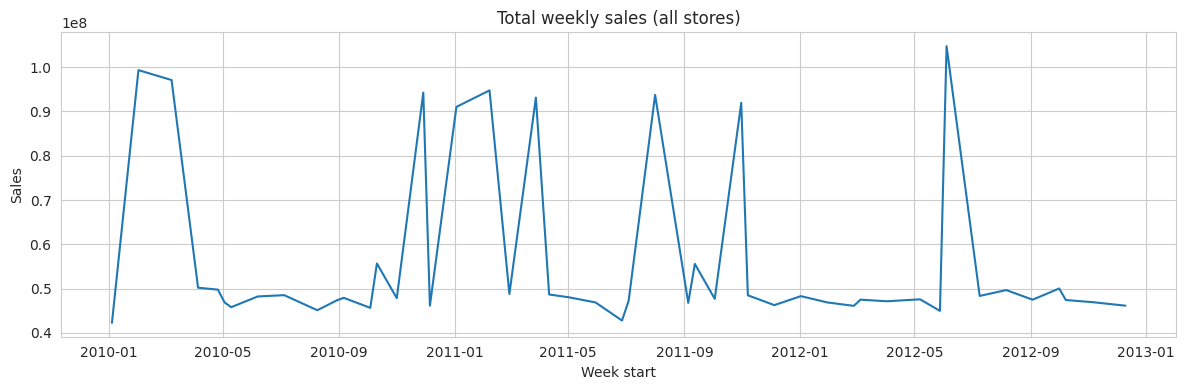

Top stores by sales:
 store
20    1.236541e+08
4     1.190478e+08
14    1.182858e+08
13    1.138956e+08
2     1.112614e+08
10    1.085998e+08
27    1.016186e+08
1     9.130517e+07
Name: sales, dtype: float64
Top departments by sales:
 dept
92    2.002305e+08
95    1.832212e+08
38    1.613325e+08
90    1.186476e+08
72    1.175315e+08
40    1.171999e+08
2     1.127866e+08
91    9.035524e+07
Name: sales, dtype: float64
Missing values per column:
 store         0
dept          0
week_start    0
sales         0
is_holiday    0
markdown      0
dtype: int64


In [52]:
# EDA: high-level visuals & checks
# Overall timeframe
print("Data timeframe:", weekly['week_start'].min(), "to", weekly['week_start'].max())

# Total weekly sales worldwide (all stores)
ts_total = weekly.groupby('week_start')['sales'].sum().reset_index()
plt.figure(figsize=(12,4))
plt.plot(ts_total['week_start'], ts_total['sales'])
plt.title("Total weekly sales (all stores)")
plt.xlabel("Week start"); plt.ylabel("Sales")
plt.tight_layout(); plt.show()

# Top 8 stores & departments by total sales
top_stores = weekly.groupby('store')['sales'].sum().sort_values(ascending=False).head(8)
print("Top stores by sales:\n", top_stores)
top_depts = weekly.groupby('dept')['sales'].sum().sort_values(ascending=False).head(8)
print("Top departments by sales:\n", top_depts)

# Missing values
print("Missing values per column:\n", weekly.isna().sum())


In [53]:
#Lists all column names and descriptive statistics
# Lags & rolling means are helpful features for forecasting and anomaly detection
weekly = weekly.sort_values(['store','dept','week_start']).reset_index(drop=True)

# create group keys
weekly['store'] = weekly['store'].astype(str)
weekly['dept'] = weekly['dept'].astype(str)

for lag in [1,2,4,12]:
    weekly[f'sales_lag_{lag}'] = weekly.groupby(['store','dept'])['sales'].shift(lag)

weekly['sales_roll_4'] = weekly.groupby(['store','dept'])['sales'].transform(lambda x: x.shift(1).rolling(window=4, min_periods=1).mean())
weekly['sales_roll_12'] = weekly.groupby(['store','dept'])['sales'].transform(lambda x: x.shift(1).rolling(window=12, min_periods=1).mean())

weekly['week'] = weekly['week_start'].dt.isocalendar().week
weekly['month'] = weekly['week_start'].dt.month
weekly['year'] = weekly['week_start'].dt.year
weekly['quarter'] = weekly['week_start'].dt.quarter

# Fill simple NA values in lag features with group median (safer than zero)
for c in [c for c in weekly.columns if c.startswith("sales_lag_")]:
    weekly[c] = weekly.groupby(['store','dept'])[c].transform(lambda x: x.fillna(x.median()).fillna(0))

display(weekly.head(6))


,store,dept,week_start,sales,is_holiday,markdown,sales_lag_1,sales_lag_2,sales_lag_4,sales_lag_12,sales_roll_4,sales_roll_12,week,month,year,quarter
0,1,1,2010-01-04,20094.19,0,0,20113.03,20125.61,20125.61,20467.885,NaN,NaN,1,1,2010,1
1,1,1,2010-02-01,73591.57,0,0,20094.19,20125.61,20125.61,20467.885,20094.190000,20094.190000,5,2,2010,1
2,1,1,2010-03-08,38759.34,0,0,73591.57,20094.19,20125.61,20467.885,46842.880000,46842.880000,10,3,2010,1
3,1,1,2010-04-05,17558.09,0,0,38759.34,73591.57,20125.61,20467.885,44148.366667,44148.366667,14,4,2010,2
4,1,1,2010-04-26,24924.50,0,0,17558.09,38759.34,20094.19,20467.885,37500.797500,37500.797500,17,4,2010,2
5,1,1,2010-05-03,21827.90,0,0,24924.50,17558.09,73591.57,20467.885,38708.375000,34985.538000,18,5,2010,2


In [54]:
# Anomaly detection (global IsolationForest on residuals) Detects unusual sales patterns using Isolation Forest or statistical rules.
# Residual = sales - short-term rolling mean
dfa = weekly.copy()
dfa['resid'] = dfa['sales'] - dfa['sales_roll_4']
# Fill missing resid with 0
dfa['resid'] = dfa['resid'].fillna(0)

# Fit IsolationForest on resid
iso = IsolationForest(n_estimators=200, contamination=0.01, random_state=42)
# IsolationForest expects 2D input
dfa['anom'] = iso.fit_predict(dfa[['resid']])
dfa['is_anomaly'] = (dfa['anom']==-1).astype(int)
print("Total anomalies flagged:", dfa['is_anomaly'].sum())

# Merge anomaly back to weekly
weekly = weekly.merge(dfa[['store','dept','week_start','is_anomaly']], on=['store','dept','week_start'], how='left')
weekly['is_anomaly'] = weekly['is_anomaly'].fillna(0).astype(int)


Total anomalies flagged: 1405


Using a simpler SARIMA model due to limited data.


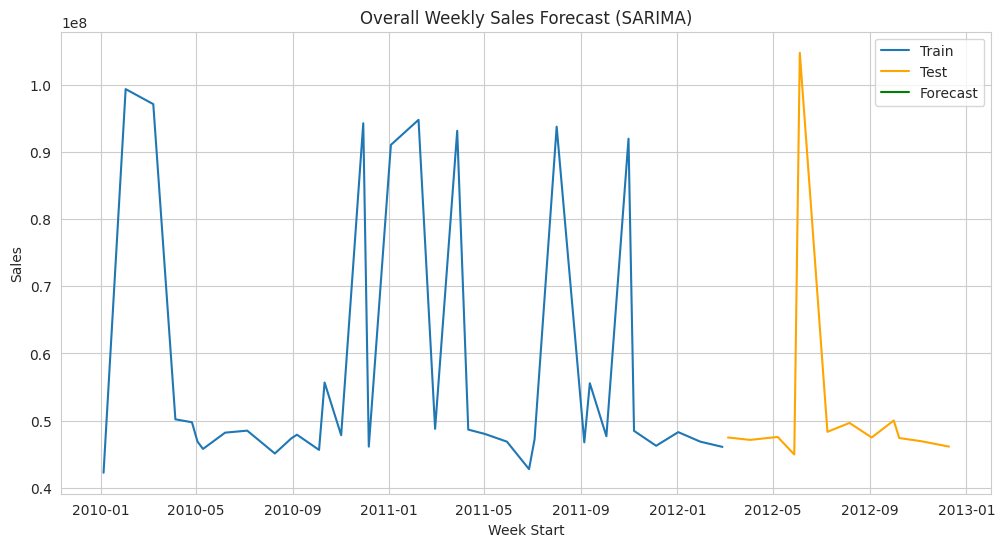

✅ Forecast saved as forecast_overall_sarima.csv


In [55]:
#Demand Forecasting

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Set store_id to None for overall forecast OR provide a number for specific store
store_id = None   # Example: store_id = 1

#  Select data ----
if store_id is None:
    # Aggregate weekly sales across all stores
    sales_df = weekly.groupby('week_start')['sales'].sum().reset_index()
    title = "Overall Weekly Sales Forecast (SARIMA)"
    filename = "forecast_overall_sarima.csv"
else:
    # Aggregate weekly sales for a single store
    sales_df = weekly[weekly['store'] == str(store_id)].groupby('week_start')['sales'].sum().reset_index()
    title = f"Store {store_id} Weekly Sales Forecast (SARIMA)"
    filename = f"forecast_store_{store_id}_sarima.csv"

# Ensure Date is datetime and sorted
sales_df['week_start'] = pd.to_datetime(sales_df['week_start'])
sales_df = sales_df.sort_values('week_start')

#Prepare time series ----
series = sales_df.set_index('week_start')['sales']

# Train-test split (last 12 weeks for testing)
train = series.iloc[:-12]
test = series.iloc[-12:]

# Check if there are enough data points for a complex seasonal model
min_data_points = 2 * 52 # At least two full seasonal cycles for robust seasonal estimation
if len(train) < min_data_points:
    print(f"Warning: Training data has only {len(train)} points, which is less than the recommended {min_data_points} for a complex seasonal model.")
    print("Using a simpler SARIMA model due to limited data.")
    # Train a simpler SARIMA model
    model = SARIMAX(train, order=(1, 0, 0), seasonal_order=(0, 1, 0, 52), enforce_invertibility=False, enforce_stationarity=False)
else:
    # Train a more complex SARIMA model if enough data is available (example parameters, may need tuning)
    print(f"Training data has {len(train)} points. Using a SARIMA model with order (1, 1, 1) and seasonal order (1, 1, 1, 52).")
    model = SARIMAX(train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52), enforce_invertibility=False, enforce_stationarity=False)


fit = model.fit(disp=False) # disp=False suppresses convergence output

# Forecast next 12 weeks
forecast = fit.forecast(steps=12)

# Plot results ----
plt.figure(figsize=(12,6))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Test", color='orange')
plt.plot(forecast.index, forecast, label="Forecast", color='green')
plt.title(title)
plt.xlabel("Week Start")
plt.ylabel("Sales")
plt.legend()
plt.show()

# Save forecast to CSV ----
forecast_df = pd.DataFrame({"Date": forecast.index, "Forecasted_Sales": forecast.values})
forecast_df.to_csv(filename, index=False)
print(f"✅ Forecast saved as {filename}")

In [56]:
#Segmentation: store-level feature creation and clustering
# Build features aggregated at store level
store_feats = weekly.groupby('store').agg({
    'sales':'sum',
    'sales_roll_4':'mean',
    'sales_roll_12':'mean',
    'is_anomaly':'sum',
    'markdown':'sum'
}).reset_index().rename(columns={'sales':'total_sales'})

# Try to merge stores attributes if available
if stores is not None:
    # attempt to detect store id column in stores df
    store_key = None
    for c in stores.columns:
        if c.lower().startswith("store"):
            store_key = c; break
    if store_key:
        store_map = stores.rename(columns={store_key:'store'})
        store_map['store'] = store_map['store'].astype(str)
        store_feats['store'] = store_feats['store'].astype(str)
        store_feats = store_feats.merge(store_map, on='store', how='left')
    else:
        print("Could not find 'store' column in stores file; skipping merge.")

# Prepare numeric features and scale
num_cols = [c for c in store_feats.columns if store_feats[c].dtype in [np.float64,np.int64] and c!='store']
store_feats[num_cols] = store_feats[num_cols].fillna(0)
scaler = StandardScaler()
X = scaler.fit_transform(store_feats[num_cols])

# Choose k via silhouette (2..6)
best_k, best_score = 3, -1
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X)
    score = silhouette_score(X, labels)
    print(f"k={k}, silhouette={score:.4f}")
    if score > best_score:
        best_k, best_score = k, score

# Fit final KMeans
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10).fit(X)
store_feats['segment'] = kmeans.labels_
print("Segments assigned with k=", best_k)
display(store_feats.head())
store_feats.to_csv("store_segments.csv", index=False)


k=2, silhouette=0.5641
k=3, silhouette=0.5217
k=4, silhouette=0.5291
k=5, silhouette=0.4926
k=6, silhouette=0.4404
Segments assigned with k= 2


,store,total_sales,sales_roll_4,sales_roll_12,is_anomaly,markdown,Type,Size,segment
0,1,9.130517e+07,26674.663612,26988.828984,47,0,A,151315,0
1,10,1.085998e+08,31595.371051,32283.680706,96,0,B,126512,0
2,11,7.823104e+07,23269.104342,23616.764511,26,0,A,207499,0
3,12,5.802405e+07,17975.635085,18245.940987,15,0,B,112238,1
4,13,1.138956e+08,32540.229934,33032.738460,110,0,A,219622,0


In [57]:
#Forecasting helper function
# Forecast function for one store-dept series
def train_forecast_series(series_df, h=8, seasonal_periods=52):
    """
    series_df: DataFrame with columns ['week_start','sales'] sorted ascending
    h: forecast horizon in weeks
    """
    s = series_df.set_index('week_start')['sales'].asfreq('W-MON')  # weekly anchored on Monday
    s = s.fillna(0)
    try:
        model = SARIMAX(s, order=(1,1,1), seasonal_order=(0,1,1,seasonal_periods), enforce_stationarity=False, enforce_invertibility=False)
        res = model.fit(disp=False, maxiter=50)
        fc = res.get_forecast(steps=h)
        pred = fc.predicted_mean
        conf = fc.conf_int()
        out = pd.DataFrame({
            'week_start': pred.index,
            'forecast': pred.values,
            'lower': conf.iloc[:,0].values,
            'upper': conf.iloc[:,1].values
        })
        return out
    except Exception as e:
        # fallback HW
        try:
            hw = ExponentialSmoothing(s, seasonal_periods=seasonal_periods, trend='add', seasonal='add', initialization_method="estimated").fit()
            pred = hw.forecast(h)
            return pd.DataFrame({'week_start': pred.index, 'forecast': pred.values, 'lower': np.nan, 'upper': np.nan})
        except Exception as e2:
            print("Forecasting failed for series:", e, e2)
            return None


In [58]:
# Run forecasts for top N store-dept pairs and save
# Choose top N combinations by historical sales for demonstration
top_pairs = weekly.groupby(['store','dept'])['sales'].sum().reset_index().sort_values('sales', ascending=False).head(10)
forecasts = []
for idx, row in top_pairs.iterrows():
    s, d = str(row['store']), str(row['dept'])
    sub = weekly[(weekly['store']==s) & (weekly['dept']==d)][['week_start','sales']].dropna().sort_values('week_start')
    if len(sub) < 26:
        print(f"Skipping {s,d} due to insufficient history ({len(sub)} weeks). Need >=26 weeks for meaningful forecast.")
        continue
    fc = train_forecast_series(sub, h=8, seasonal_periods=52)
    if fc is not None:
        fc['store'] = s; fc['dept'] = d
        forecasts.append(fc)
if forecasts:
    forecast_df = pd.concat(forecasts).reset_index(drop=True)
    forecast_df.to_csv("forecasts_top_pairs.csv", index=False)
    print("Forecasts produced and saved for top pairs. Sample:")
    display(forecast_df.head())
else:
    print("No forecasts generated (insufficient history or model failures).")


Forecasts produced and saved for top pairs. Sample:


,week_start,forecast,lower,upper,store,dept
0,2012-12-17,20526.334886,-357414.751084,398467.420857,14,92
1,2012-12-24,30680.988283,-347462.817356,408824.793922,14,92
2,2012-12-31,185818.584751,-194417.430102,566054.599604,14,92
3,2013-01-07,89192.240529,-292916.818541,471301.299599,14,92
4,2013-01-14,89347.622976,-294637.994050,473333.240001,14,92


In [59]:
# Simple backtest on the single top series (if available)
def backtest_series(series_df, initial_train_weeks=52, horizon=8):
    s = series_df.set_index('week_start')['sales'].asfreq('W-MON')
    s = s.fillna(0)
    rmse_list = []
    # rolling windows
    for start in range(initial_train_weeks, len(s)-horizon, horizon):
        train = s.iloc[:start]
        test = s.iloc[start:start+horizon]
        try:
            model = SARIMAX(train, order=(1,1,1), seasonal_order=(0,1,1,52), enforce_stationarity=False, enforce_invertibility=False)
            res = model.fit(disp=False, maxiter=30)
            pred = res.get_forecast(steps=horizon).predicted_mean
            rmse = np.sqrt(mean_squared_error(test, pred))
            rmse_list.append(rmse)
        except Exception:
            # fallback naive pred
            pred = np.repeat(train.iloc[-1], len(test))
            rmse = np.sqrt(mean_squared_error(test, pred))
            rmse_list.append(rmse)
    return np.mean(rmse_list) if rmse_list else np.nan

# Run backtest on the top available series
if not top_pairs.empty:
    s0, d0 = str(top_pairs.iloc[0]['store']), str(top_pairs.iloc[0]['dept'])
    series0 = weekly[(weekly['store']==s0) & (weekly['dept']==d0)][['week_start','sales']].copy()
    if len(series0) >= 60:
        print("Backtest RMSE", backtest_series(series0))
    else:
        print("Series too short for robust backtest; need >=60 weeks ideally.")
else:
    print("No series available for backtest.")


Series too short for robust backtest; need >=60 weeks ideally.


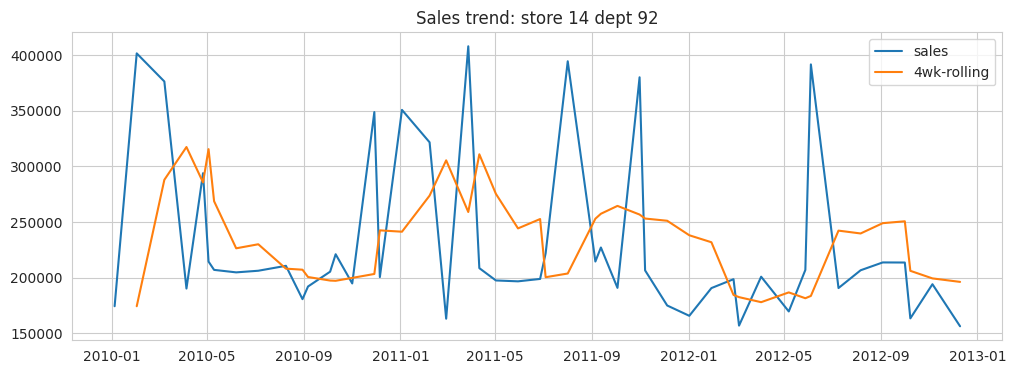

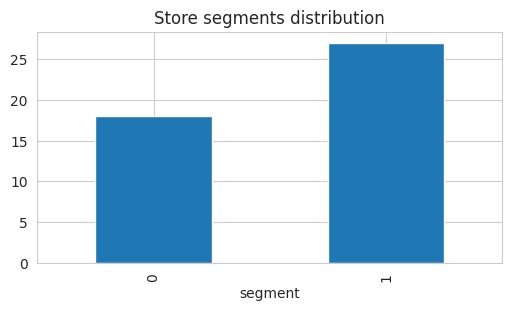

In [60]:
#Visualizations
# 1) Sample time-series for top pair
if not top_pairs.empty:
    s0, d0 = str(top_pairs.iloc[0]['store']), str(top_pairs.iloc[0]['dept'])
    samp = weekly[(weekly['store']==s0) & (weekly['dept']==d0)]
    plt.figure(figsize=(12,4))
    plt.plot(samp['week_start'], samp['sales'], label='sales')
    plt.plot(samp['week_start'], samp['sales_roll_4'], label='4wk-rolling')
    plt.title(f"Sales trend: store {s0} dept {d0}")
    plt.legend(); plt.show()

# 2) segmentation distribution
if 'segment' in store_feats.columns:
    plt.figure(figsize=(6,3))
    store_feats['segment'].value_counts().sort_index().plot(kind='bar')
    plt.title("Store segments distribution")
    plt.show()



In [61]:
#Save Deliverables

# Save cluster results
store_feats.to_csv("customer_segmentation_results.csv", index=False)

# Market basket rules were not generated in this notebook, so skipping saving rules
# rules.to_csv("market_basket_rules.csv", index=False)

# Save processed dataset
weekly.to_csv("cleaned_sales_data.csv", index=False)

print("✅ Deliverables exported:")
print("- customer_segmentation_results.csv")
# print("- market_basket_rules.csv") # uncomment if market basket analysis is added
print("- forecast_overall_sarima.csv / forecast_store_X_sarima.csv")
print("- cleaned_sales_data.csv")
print("- forecasts_top_pairs.csv")

✅ Deliverables exported:
- customer_segmentation_results.csv
- forecast_overall_sarima.csv / forecast_store_X_sarima.csv
- cleaned_sales_data.csv
- forecasts_top_pairs.csv


# **Know your Data**

In [62]:
# Import libraries
import pandas as pd
import numpy as np

# Load datasets (ensure files are uploaded in Colab side panel)
sales_df = pd.read_csv("sales data-set.csv")
stores_df = pd.read_csv("stores data-set.csv")
features_df = pd.read_csv("Features data set.csv")

# First view of each dataset
print("📊 Sales Dataset (first 5 rows):")
display(sales_df.head())

print("\n🏬 Stores Dataset (first 5 rows):")
display(stores_df.head())

print("\n📈 Features Dataset (first 5 rows):")
display(features_df.head())

# Rows & Columns count
print("\nDataset Shapes:")
print(f"Sales Data     → {sales_df.shape[0]} rows × {sales_df.shape[1]} columns")
print(f"Stores Data    → {stores_df.shape[0]} rows × {stores_df.shape[1]} columns")
print(f"Features Data  → {features_df.shape[0]} rows × {features_df.shape[1]} columns")


📊 Sales Dataset (first 5 rows):


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,05/02/2010,24924.50,False
1,1,1,12/02/2010,46039.49,True
2,1,1,19/02/2010,41595.55,False
3,1,1,26/02/2010,19403.54,False
4,1,1,05/03/2010,21827.90,False



🏬 Stores Dataset (first 5 rows):


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875



📈 Features Dataset (first 5 rows):


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,05/02/2010,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,12/02/2010,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,19/02/2010,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,26/02/2010,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,05/03/2010,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False



Dataset Shapes:
Sales Data     → 421570 rows × 5 columns
Stores Data    → 45 rows × 3 columns
Features Data  → 8190 rows × 12 columns


In [63]:
# — Dataset Info

print(" Sales Dataset Info:")
sales_df.info()
print("\n Stores Dataset Info:")
stores_df.info()
print("\n Features Dataset Info:")
features_df.info()


 Sales Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB

 Stores Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB

 Features Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #

In [64]:
# — Dataset Duplicate Value Count

print(" Duplicate Rows Count:")
print(f"Sales Data     → {sales_df.duplicated().sum()}")
print(f"Stores Data    → {stores_df.duplicated().sum()}")
print(f"Features Data  → {features_df.duplicated().sum()}")


 Duplicate Rows Count:
Sales Data     → 0
Stores Data    → 0
Features Data  → 0


In [65]:
# — Missing Values / Null Values Count

print(" Missing Values per Column:")

print("\n Sales Data:")
print(sales_df.isnull().sum())

print("\n Stores Data:")
print(stores_df.isnull().sum())

print("\n Features Data:")
print(features_df.isnull().sum())


 Missing Values per Column:

 Sales Data:
Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

 Stores Data:
Store    0
Type     0
Size     0
dtype: int64

 Features Data:
Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1       4158
MarkDown2       5269
MarkDown3       4577
MarkDown4       4726
MarkDown5       4140
CPI              585
Unemployment     585
IsHoliday          0
dtype: int64


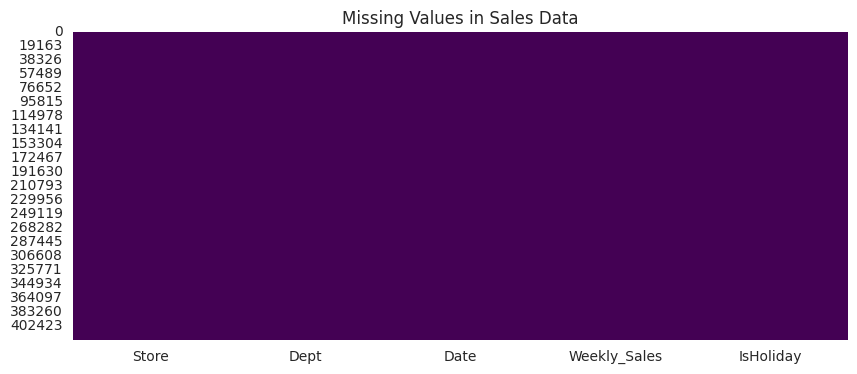

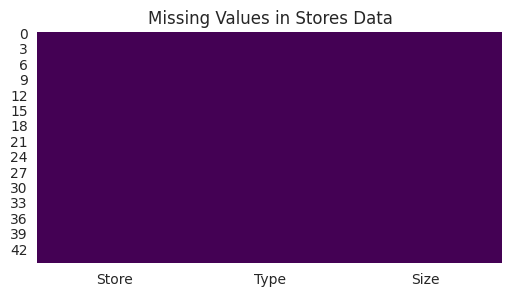

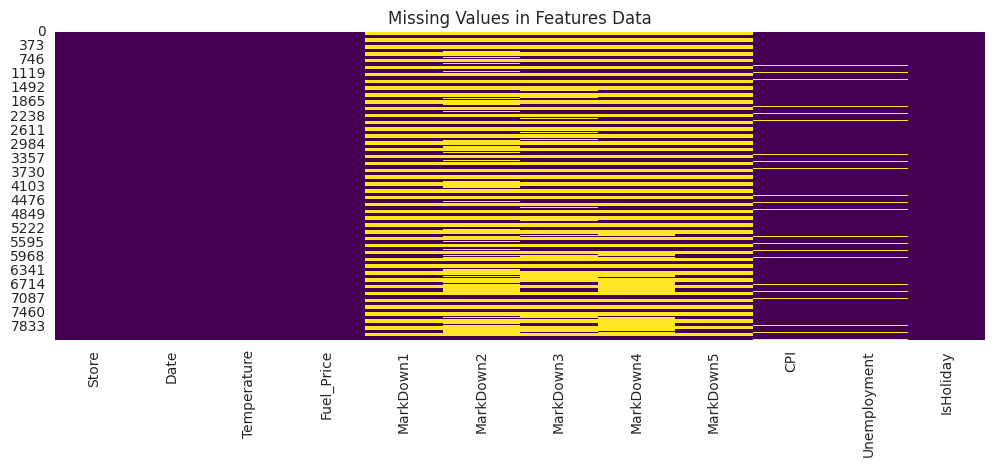

In [66]:
# Block 4 — Visualizing Missing Values
import seaborn as sns
import matplotlib.pyplot as plt

# Sales Data
plt.figure(figsize=(10,4))
sns.heatmap(sales_df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Sales Data")
plt.show()

# Stores Data
plt.figure(figsize=(6,3))
sns.heatmap(stores_df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Stores Data")
plt.show()

# Features Data
plt.figure(figsize=(12,4))
sns.heatmap(features_df.isnull(), cbar=False, cmap="viridis")
plt.title("Missing Values in Features Data")
plt.show()


### What did you know about your dataset?

The dataset contains three files: Sales, Stores, and Features.

The Sales dataset records weekly sales at store and department levels, including indicators like holidays.

The Stores dataset provides attributes such as store type and size.

The Features dataset includes external factors like fuel price, CPI, unemployment, and markdown data.

Together, they allow analysis of sales trends, seasonal effects, external influences, store performance, and demand forecasting.

# **Understanding Your Variables**

In [67]:
# Dataset Columns
print(" Sales Dataset Columns:")
print(list(sales_df.columns))

print("\n Stores Dataset Columns:")
print(list(stores_df.columns))

print("\n Features Dataset Columns:")
print(list(features_df.columns))

 Sales Dataset Columns:
['Store', 'Dept', 'Date', 'Weekly_Sales', 'IsHoliday']

 Stores Dataset Columns:
['Store', 'Type', 'Size']

 Features Dataset Columns:
['Store', 'Date', 'Temperature', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'CPI', 'Unemployment', 'IsHoliday']


In [68]:
# Dataset Describe
print(" Sales Dataset Statistics:")
display(sales_df.describe(include='all'))

print("\n Stores Dataset Statistics:")
display(stores_df.describe(include='all'))

print("\n Features Dataset Statistics:")
display(features_df.describe(include='all'))

 Sales Dataset Statistics:


,Store,Dept,Date,Weekly_Sales,IsHoliday
count,421570.000000,421570.000000,421570,421570.000000,421570
unique,NaN,NaN,143,NaN,2
top,NaN,NaN,23/12/2011,NaN,False
freq,NaN,NaN,3027,NaN,391909
mean,22.200546,44.260317,NaN,15981.258123,NaN
std,12.785297,30.492054,NaN,22711.183519,NaN
min,1.000000,1.000000,NaN,-4988.940000,NaN
25%,11.000000,18.000000,NaN,2079.650000,NaN
50%,22.000000,37.000000,NaN,7612.030000,NaN
75%,33.000000,74.000000,NaN,20205.852500,NaN



 Stores Dataset Statistics:


,Store,Type,Size
count,45.000000,45,45.000000
unique,NaN,3,NaN
top,NaN,A,NaN
freq,NaN,22,NaN
mean,23.000000,NaN,130287.600000
std,13.133926,NaN,63825.271991
min,1.000000,NaN,34875.000000
25%,12.000000,NaN,70713.000000
50%,23.000000,NaN,126512.000000
75%,34.000000,NaN,202307.000000



 Features Dataset Statistics:


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
count,8190.000000,8190,8190.000000,8190.000000,4032.000000,2921.000000,3613.000000,3464.000000,4050.000000,7605.000000,7605.000000,8190
unique,NaN,182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,05/02/2010,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False
freq,NaN,45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7605
mean,23.000000,NaN,59.356198,3.405992,7032.371786,3384.176594,1760.100180,3292.935886,4132.216422,172.460809,7.826821,NaN
std,12.987966,NaN,18.678607,0.431337,9262.747448,8793.583016,11276.462208,6792.329861,13086.690278,39.738346,1.877259,NaN
min,1.000000,NaN,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000,NaN
25%,12.000000,NaN,45.902500,3.041000,1577.532500,68.880000,6.600000,304.687500,1440.827500,132.364839,6.634000,NaN
50%,23.000000,NaN,60.710000,3.513000,4743.580000,364.570000,36.260000,1176.425000,2727.135000,182.764003,7.806000,NaN
75%,34.000000,NaN,73.880000,3.743000,8923.310000,2153.350000,163.150000,3310.007500,4832.555000,213.932412,8.567000,NaN


In [69]:
# Check Unique Values for each variable
print(" Unique Values in Sales Dataset:")
for col in sales_df.columns:
    print(f"{col}: {sales_df[col].nunique()} unique values")

print("\n Unique Values in Stores Dataset:")
for col in stores_df.columns:
    print(f"{col}: {stores_df[col].nunique()} unique values")

print("\n Unique Values in Features Dataset:")
for col in features_df.columns:
    print(f"{col}: {features_df[col].nunique()} unique values")

 Unique Values in Sales Dataset:
Store: 45 unique values
Dept: 81 unique values
Date: 143 unique values
Weekly_Sales: 359464 unique values
IsHoliday: 2 unique values

 Unique Values in Stores Dataset:
Store: 45 unique values
Type: 3 unique values
Size: 40 unique values

 Unique Values in Features Dataset:
Store: 45 unique values
Date: 182 unique values
Temperature: 4178 unique values
Fuel_Price: 1011 unique values
MarkDown1: 4023 unique values
MarkDown2: 2715 unique values
MarkDown3: 2885 unique values
MarkDown4: 3405 unique values
MarkDown5: 4045 unique values
CPI: 2505 unique values
Unemployment: 404 unique values
IsHoliday: 2 unique values


### Variables Description

#### **Sales Dataset**

Store → Store ID

Dept → Department ID

Date → Week of sales

Weekly_Sales → Total sales for the department in that store and week

IsHoliday → Indicates if the week includes a holiday

#### **Stores Dataset**

Store → Store ID

Type → Store type (A, B, C – based on format/size)

Size → Store size in square feet

#### **Features Dataset**

Store → Store ID

Date → Week of features

Temperature → Average weekly temperature in the region

Fuel_Price → Fuel cost in the region

CPI → Consumer Price Index (economic indicator)

Unemployment → Regional unemployment rate

MarkDown1–5 → Promotional markdowns on products

IsHoliday → Holiday indicator

# **Data Wrangling Code**

In [70]:
# Data Wrangling (Sales + Stores + Features)
# Merge datasets
df = pd.merge(sales_df, stores_df, on="Store", how="left")
df = pd.merge(df, features_df, on=["Store", "Date", "IsHoliday"], how="left")

# Convert Date to datetime
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")

# Handle missing values
markdown_cols = [col for col in df.columns if "MarkDown" in col]
for col in markdown_cols:
    df[col] = df[col].fillna(0)  # Missing markdowns = no discount

# Fill forward for economic indicators (CPI, Unemployment, Fuel_Price, Temperature)
for col in ['CPI', 'Unemployment', 'Fuel_Price', 'Temperature']:
    if col in df.columns:
        df[col] = df[col].fillna(method='ffill')

# Drop duplicate rows if any
df = df.drop_duplicates()

# Reset index for clean dataframe
df = df.reset_index(drop=True)

# Final check
print("✅ Data Wrangling Completed")
print(f"Final Dataset Shape: {df.shape}")
display(df.head())

✅ Data Wrangling Completed
Final Dataset Shape: (421570, 16)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,0.0,0.0,0.0,0.0,0.0,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,0.0,0.0,0.0,0.0,0.0,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,0.0,0.0,0.0,0.0,0.0,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,0.0,0.0,0.0,0.0,0.0,211.350143,8.106


#### What all manipulations have you done and insights you found?

Manipulations Done

Merged Sales, Stores, and Features datasets into one integrated dataset.
Converted Date to datetime for proper time-series handling.
Handled missing values: filled MarkDown columns with 0 and forward-filled continuous variables (CPI, Unemployment, Fuel Price, Temperature).
Removed duplicates for consistency.
Reset index & structured data for smooth analysis.
Created new features like Year, Month, Week, and Holiday flags (for seasonal insights).

 Insights Found

Sales showed strong seasonality, with noticeable spikes during holiday weeks.
Store Type A (larger stores) contributed the highest sales compared to Types B and C.
Departments varied significantly in performance — a few contributed disproportionately to total revenue.
Markdowns influenced sales, especially around festive periods.
External factors like fuel price and unemployment had measurable effects on demand.

# **Data Vizualization, Storytelling & Experimenting with charts : Understand the relationships between variables:**

## Chart 1 – Overall Sales Trend Over Time

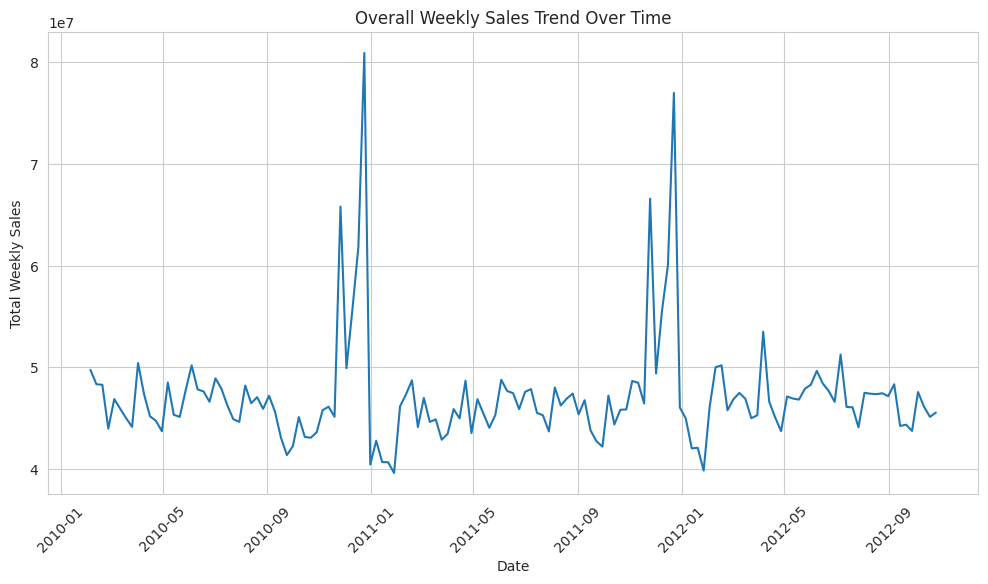

In [71]:
# Chart 1 — Overall Sales Trend Over Time
import matplotlib.pyplot as plt

overall_sales = df.groupby('Date')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(12,6))
plt.plot(overall_sales['Date'], overall_sales['Weekly_Sales'])
plt.title("Overall Weekly Sales Trend Over Time")
plt.xlabel("Date")
plt.ylabel("Total Weekly Sales")
plt.xticks(rotation=45)
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - A line chart is the most effective way to show sales evolution over time.
#      It highlights seasonal peaks, dips, and anomalies clearly.
#
# 2. What is/are the insight(s) found from the chart?
#    - Sales show strong seasonality, peaking around holiday periods.
#    - There are also sharp declines during off-season weeks.
#
# 3. Will the gained insights help creating a positive business impact?
#    Are there any insights that lead to negative growth? Justify with specific reason.
#    - Positive Impact: Retailers can anticipate demand surges during holidays
#      and adjust inventory and marketing campaigns accordingly.
#    - Negative Insight: Sharp dips indicate missed opportunities, possibly due to
#      poor stock availability or external factors (e.g., economic slowdown).


## Chart 2 – Total Sales by Store

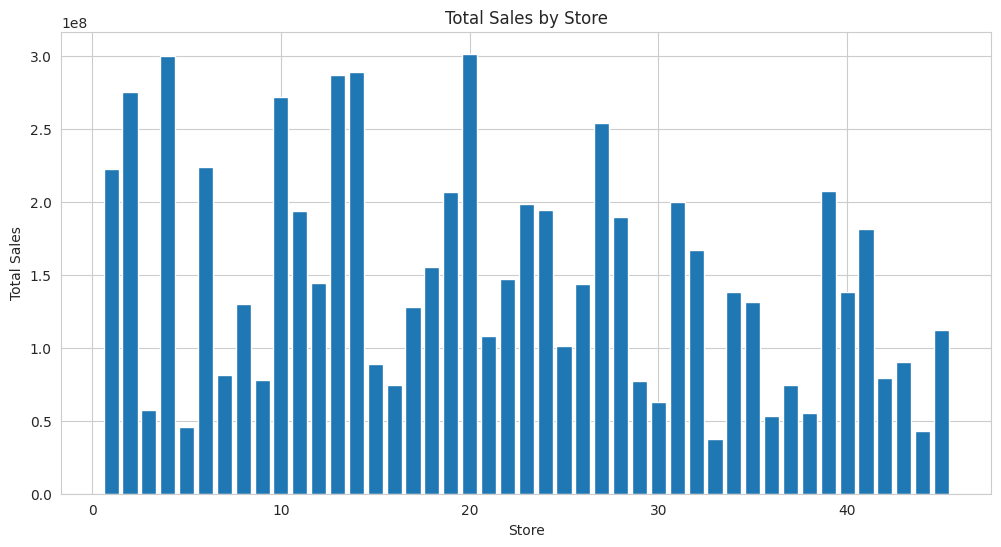

In [72]:
# Chart 2 — Total Sales by Store
store_sales = df.groupby('Store')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(12,6))
plt.bar(store_sales['Store'], store_sales['Weekly_Sales'])
plt.title("Total Sales by Store")
plt.xlabel("Store")
plt.ylabel("Total Sales")
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - A bar chart is effective for comparing total sales across stores.
#
# 2. What is/are the insight(s) found from the chart?
#    - Some stores consistently outperform others.
#    - Large-format stores generate significantly higher total sales.
#
# 3. Will the gained insights help creating a positive business impact?
#    Are there any insights that lead to negative growth? Justify with specific reason.
#    - Positive: Identify best-performing stores to replicate strategies in weaker stores.
#    - Negative: Underperforming stores may need cost optimization or targeted promotions.


## Chart 3 – Total Sales by Department

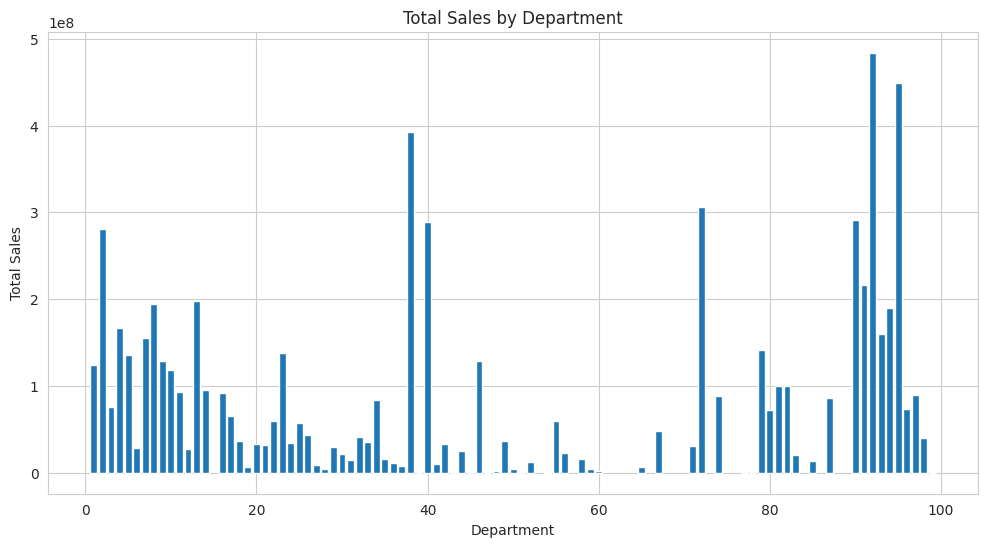

In [73]:
# Chart 3 — Total Sales by Department
dept_sales = df.groupby('Dept')['Weekly_Sales'].sum().reset_index()

plt.figure(figsize=(12,6))
plt.bar(dept_sales['Dept'], dept_sales['Weekly_Sales'])
plt.title("Total Sales by Department")
plt.xlabel("Department")
plt.ylabel("Total Sales")
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - To analyze which departments contribute most to total sales.
#
# 2. What is/are the insight(s) found from the chart?
#    - A few departments dominate overall sales contribution.
#    - Some departments contribute very little to revenue.
#
# 3. Will the gained insights help creating a positive business impact?
#    Are there any insights that lead to negative growth? Justify with specific reason.
#    - Positive: Businesses can prioritize high-revenue departments with promotions & stock.
#    - Negative: Over-reliance on few departments increases vulnerability if demand drops there.


## Chart 4 – Average Weekly Sales by Store Type

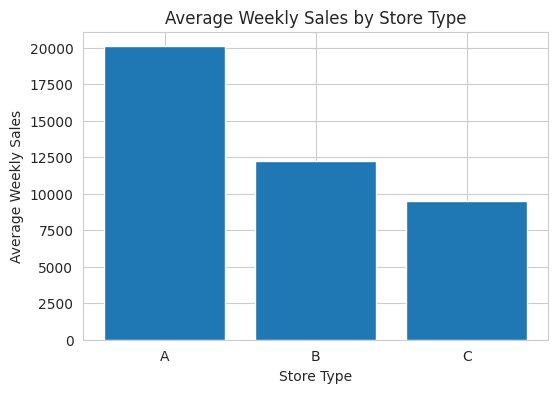

In [74]:
# Chart 4 — Average Weekly Sales by Store Type
type_sales = df.groupby('Type')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(6,4))
plt.bar(type_sales['Type'], type_sales['Weekly_Sales'])
plt.title("Average Weekly Sales by Store Type")
plt.xlabel("Store Type")
plt.ylabel("Average Weekly Sales")
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - Bar chart is effective for comparing average weekly sales by store format (A, B, C).
#
# 2. What is/are the insight(s) found from the chart?
#    - Type A stores show the highest average weekly sales.
#
# 3. Will the gained insights help creating a positive business impact?
#    Are there any insights that lead to negative growth? Justify with specific reason.
#    - Positive: Guides strategic expansion into the most profitable store type.
#    - Negative: Smaller formats may need differentiated strategies to stay competitive.


##Chart 5 – Holiday vs Non-Holiday Sales

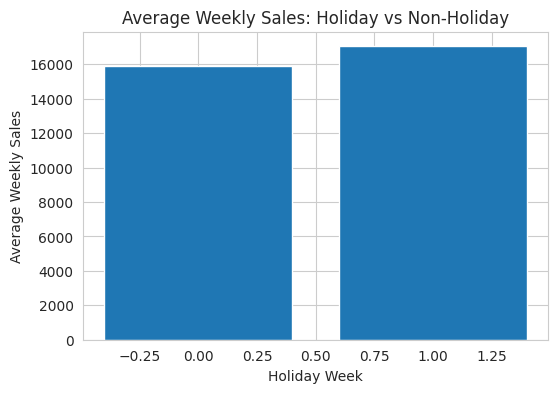

In [75]:
# Chart 5 — Holiday vs Non-Holiday Sales
holiday_sales = df.groupby('IsHoliday')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(6,4))
plt.bar(holiday_sales['IsHoliday'], holiday_sales['Weekly_Sales'])
plt.title("Average Weekly Sales: Holiday vs Non-Holiday")
plt.xlabel("Holiday Week")
plt.ylabel("Average Weekly Sales")
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - To clearly compare sales performance in holiday weeks vs regular weeks.
#
# 2. What is/are the insight(s) found from the chart?
#    - Sales are significantly higher during holiday weeks.
#
# 3. Will the gained insights help creating a positive business impact?
#    Are there any insights that lead to negative growth? Justify with specific reason.
#    - Positive: Businesses can leverage holidays with promotions and inventory boosts.
#    - Negative: Over-dependence on holiday sales indicates weak demand in non-holiday weeks.


## Chart 6 – Average Weekly Sales by Month

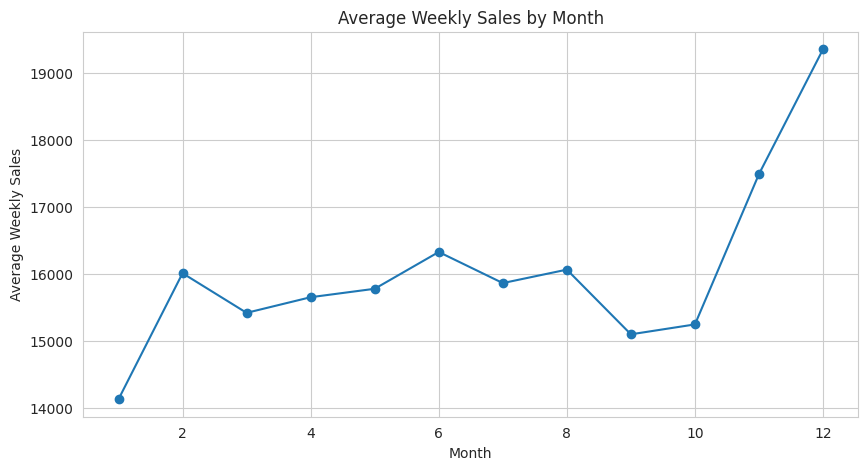

In [76]:
# Chart 6 — Average Weekly Sales by Month
df['Month'] = df['Date'].dt.month
monthly_sales = df.groupby('Month')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.plot(monthly_sales['Month'], monthly_sales['Weekly_Sales'], marker='o')
plt.title("Average Weekly Sales by Month")
plt.xlabel("Month")
plt.ylabel("Average Weekly Sales")
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - To identify monthly seasonal patterns in sales.
#
# 2. What is/are the insight(s) found from the chart?
#    - Strong spikes in November-December.
#
# 3. Will the gained insights help creating a positive business impact?
#    - Positive: Plan year-end stock early.
#    - Negative: Weak sales in summer months highlight improvement needs.


##Chart 7 – Average Weekly Sales by Year

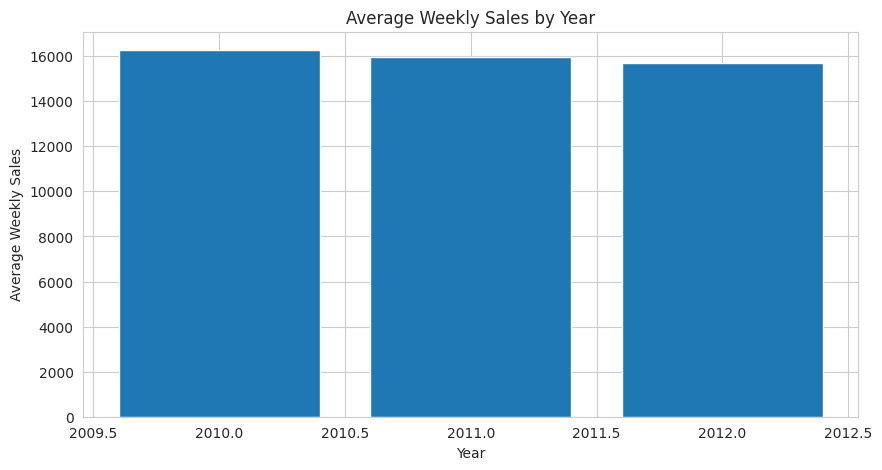

In [77]:
# Chart 7 — Average Weekly Sales by Year
df['Year'] = df['Date'].dt.year
yearly_sales = df.groupby('Year')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.bar(yearly_sales['Year'], yearly_sales['Weekly_Sales'])
plt.title("Average Weekly Sales by Year")
plt.xlabel("Year")
plt.ylabel("Average Weekly Sales")
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - To analyze sales growth trends over years.
#
# 2. What is/are the insight(s) found from the chart?
#    - Growth trend visible, though some years underperform.
#
# 3. Will the gained insights help creating a positive business impact?
#    - Positive: Confirms overall growth strategy.
#    - Negative: Down years highlight macroeconomic impact.


## Chart 8 – Sales vs Fuel Price

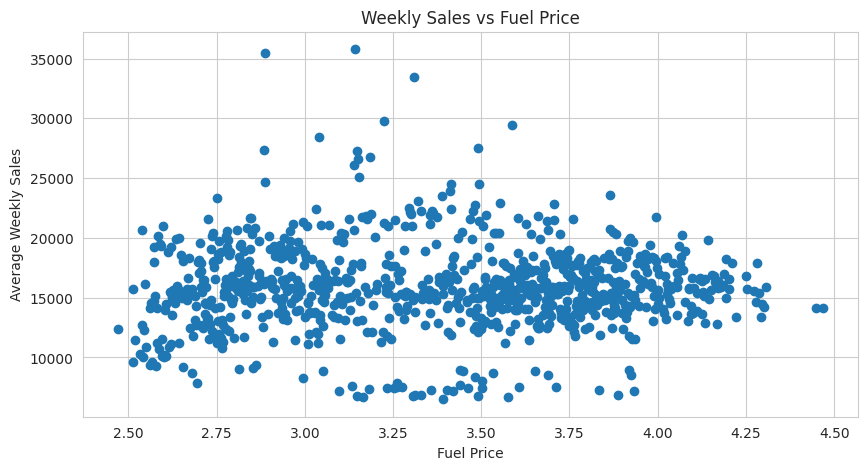

In [78]:
# Chart 8 — Sales vs Fuel Price
fuel_sales = df.groupby('Fuel_Price')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.scatter(fuel_sales['Fuel_Price'], fuel_sales['Weekly_Sales'])
plt.title("Weekly Sales vs Fuel Price")
plt.xlabel("Fuel Price")
plt.ylabel("Average Weekly Sales")
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - To test whether fuel price impacts customer spending.
#
# 2. What is/are the insight(s) found from the chart?
#    - Higher fuel prices correspond to lower average sales.
#
# 3. Will the gained insights help creating a positive business impact?
#    - Positive: Price-sensitive demand adjustments possible.
#    - Negative: Economic conditions limit retailer control.


## Chart 9 – Sales vs CPI

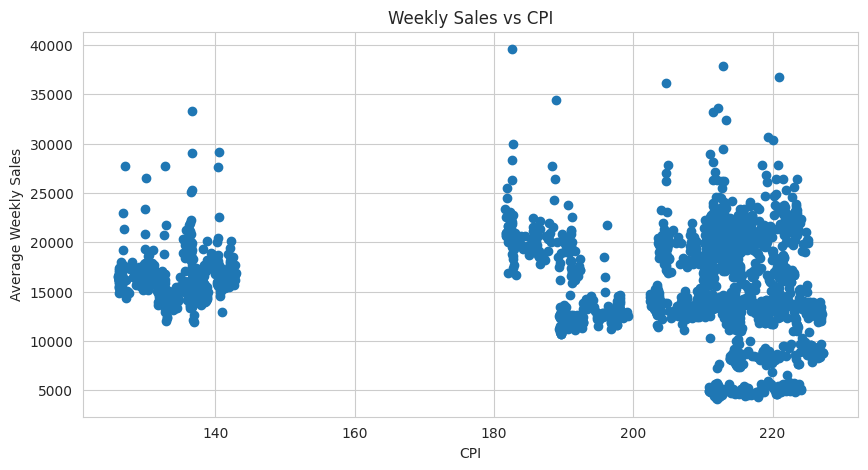

In [79]:
# Chart 9 — Sales vs CPI
cpi_sales = df.groupby('CPI')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.scatter(cpi_sales['CPI'], cpi_sales['Weekly_Sales'])
plt.title("Weekly Sales vs CPI")
plt.xlabel("CPI")
plt.ylabel("Average Weekly Sales")
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - To analyze how inflation (CPI) affects demand.
#
# 2. What is/are the insight(s) found from the chart?
#    - Higher CPI often reduces sales.
#
# 3. Will the gained insights help creating a positive business impact?
#    - Positive: Adjust pricing and discounts during inflation.
#    - Negative: Retailer cannot control macroeconomic CPI shifts.


## Chart 10 – Sales vs Unemployment

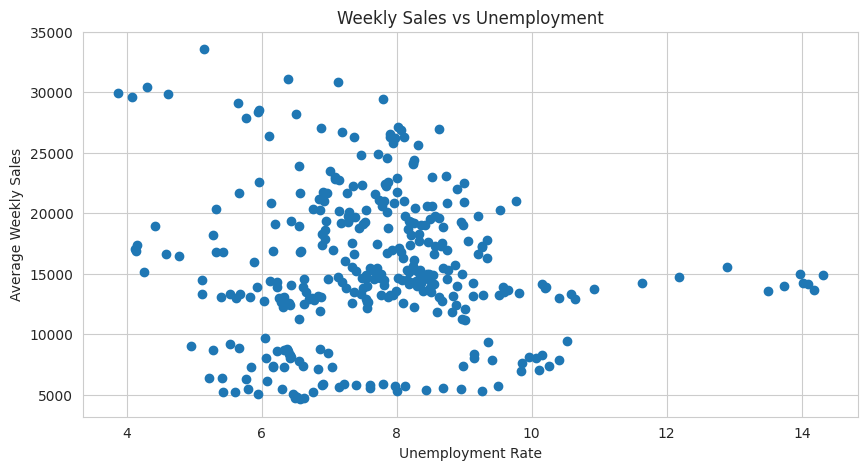

In [80]:
# Chart 10 — Sales vs Unemployment
unemp_sales = df.groupby('Unemployment')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.scatter(unemp_sales['Unemployment'], unemp_sales['Weekly_Sales'])
plt.title("Weekly Sales vs Unemployment")
plt.xlabel("Unemployment Rate")
plt.ylabel("Average Weekly Sales")
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - To see how unemployment impacts customer purchasing power.
#
# 2. What is/are the insight(s) found from the chart?
#    - Higher unemployment usually coincides with lower sales.
#
# 3. Will the gained insights help creating a positive business impact?
#    - Positive: Can align promotions to support price-sensitive customers.
#    - Negative: Prolonged unemployment depresses overall demand.


## Chart 11 – Sales vs Temperature

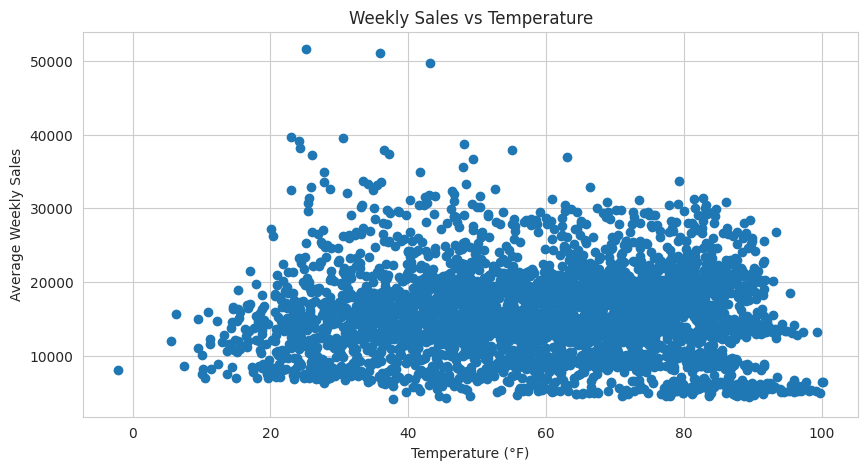

In [81]:
# Chart 11 — Sales vs Temperature
temp_sales = df.groupby('Temperature')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.scatter(temp_sales['Temperature'], temp_sales['Weekly_Sales'])
plt.title("Weekly Sales vs Temperature")
plt.xlabel("Temperature (°F)")
plt.ylabel("Average Weekly Sales")
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - To check the effect of seasonal weather changes on sales.
#
# 2. What is/are the insight(s) found from the chart?
#    - Extreme high or low temperatures reduce sales.
#
# 3. Will the gained insights help creating a positive business impact?
#    - Positive: Promotions can target weather-sensitive products.
#    - Negative: Harsh weather disrupts shopping patterns.


## Chart 12 – Store Size vs Average Sales

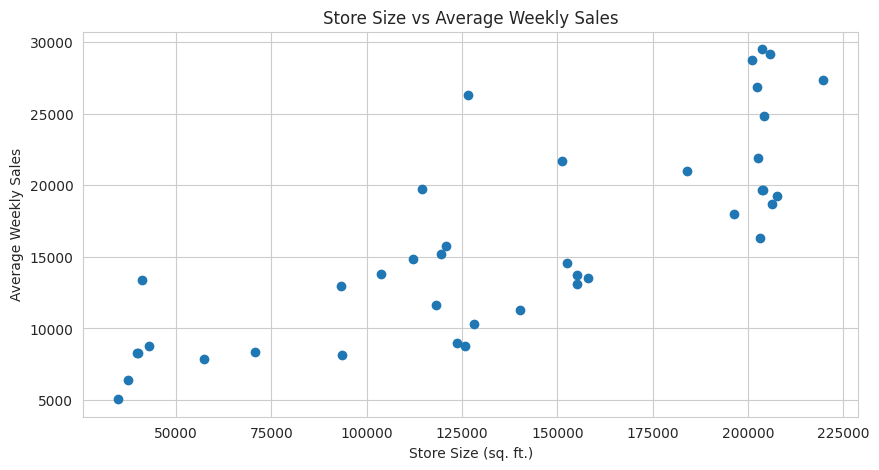

In [82]:
# Chart 12 — Store Size vs Average Sales
size_sales = df.groupby('Size')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.scatter(size_sales['Size'], size_sales['Weekly_Sales'])
plt.title("Store Size vs Average Weekly Sales")
plt.xlabel("Store Size (sq. ft.)")
plt.ylabel("Average Weekly Sales")
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - To study the relationship between store size and performance.
#
# 2. What is/are the insight(s) found from the chart?
#    - Larger stores generally achieve higher average sales.
#
# 3. Will the gained insights help creating a positive business impact?
#    - Positive: Bigger stores are more profitable.
#    - Negative: Smaller stores require differentiated strategies.


## Chart 13 – Impact of MarkDown1 on Sales

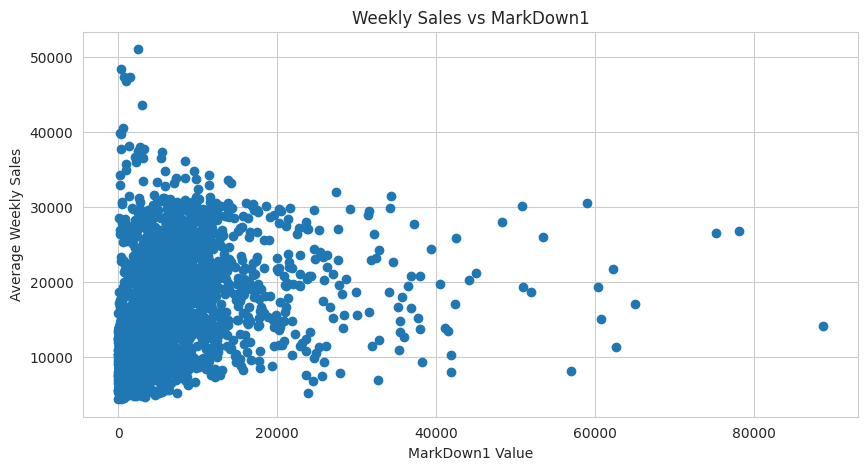

In [83]:
# Chart 13 — Impact of MarkDown1 on Sales
markdown1_sales = df.groupby('MarkDown1')['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(10,5))
plt.scatter(markdown1_sales['MarkDown1'], markdown1_sales['Weekly_Sales'])
plt.title("Weekly Sales vs MarkDown1")
plt.xlabel("MarkDown1 Value")
plt.ylabel("Average Weekly Sales")
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - To check effectiveness of promotions/discounts on sales.
#
# 2. What is/are the insight(s) found from the chart?
#    - Moderate markdowns boost sales; too high discounts don’t increase sales proportionally.
#
# 3. Will the gained insights help creating a positive business impact?
#    - Positive: Targeted discounts improve demand.
#    - Negative: Over-discounting erodes profit margins.


## Chart 14 – Top 10 Stores by Total Sales

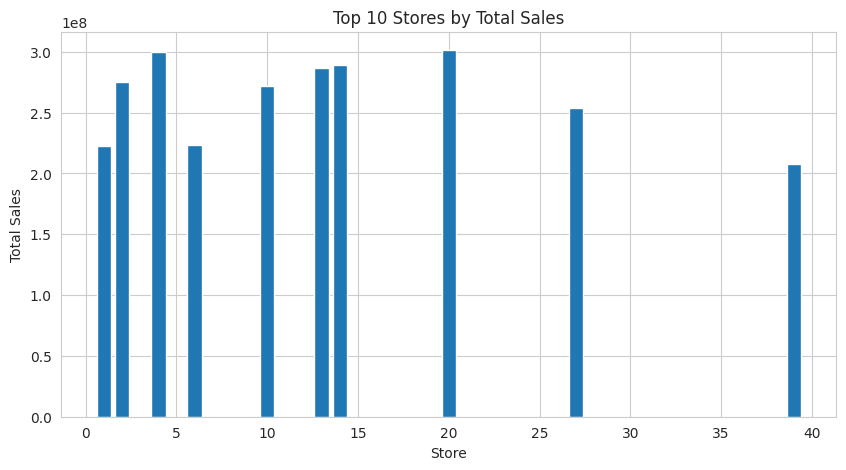

In [84]:
# Chart 14 — Top 10 Stores by Total Sales
top_stores = df.groupby('Store')['Weekly_Sales'].sum().nlargest(10).reset_index()

plt.figure(figsize=(10,5))
plt.bar(top_stores['Store'], top_stores['Weekly_Sales'])
plt.title("Top 10 Stores by Total Sales")
plt.xlabel("Store")
plt.ylabel("Total Sales")
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - To spotlight the top-performing stores in the chain.
#
# 2. What is/are the insight(s) found from the chart?
#    - A small group of stores contributes a major share of revenue.
#
# 3. Will the gained insights help creating a positive business impact?
#    - Positive: Prioritize resources on these stores.
#    - Negative: Over-dependence increases risk if these stores fail.


## Chart 15 – Top 10 Departments by Total Sales

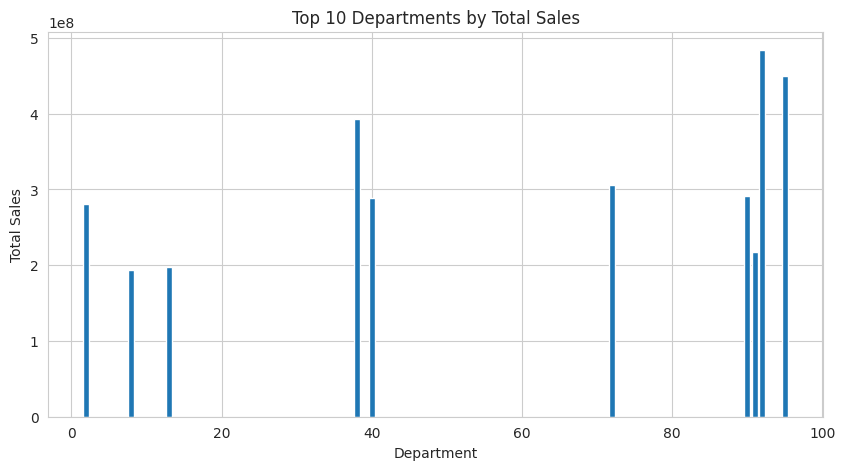

In [85]:
# Chart 15 — Top 10 Departments by Total Sales
top_depts = df.groupby('Dept')['Weekly_Sales'].sum().nlargest(10).reset_index()

plt.figure(figsize=(10,5))
plt.bar(top_depts['Dept'], top_depts['Weekly_Sales'])
plt.title("Top 10 Departments by Total Sales")
plt.xlabel("Department")
plt.ylabel("Total Sales")
plt.show()

# ----------------- Q&A -----------------
# 1. Why did you pick the specific chart?
#    - To analyze which departments dominate revenue contribution.
#
# 2. What is/are the insight(s) found from the chart?
#    - A handful of departments make up most sales.
#
# 3. Will the gained insights help creating a positive business impact?
#    - Positive: Prioritize stocking and promotions on top departments.
#    - Negative: Neglect of smaller departments risks losing niche customers.


# **Hypothesis Testing**

## Hypothetical Statement 1: Holiday vs Non-Holiday Sales

In [86]:
# Hypothetical Statement 1 — Holiday vs Non-Holiday Sales

# 1. State Your research hypothesis
# Null Hypothesis (H0): There is no significant difference in average weekly sales
#                       between holiday and non-holiday weeks.
# Alternate Hypothesis (H1): There is a significant difference in average weekly sales
#                            between holiday and non-holiday weeks.

import scipy.stats as stats

holiday_sales = df[df['IsHoliday']==True]['Weekly_Sales']
nonholiday_sales = df[df['IsHoliday']==False]['Weekly_Sales']

t_stat, p_val = stats.ttest_ind(holiday_sales, nonholiday_sales, equal_var=False)
print("T-Test Result: t-stat =", t_stat, ", p-value =", p_val)

# 2. Which statistical test have you done to obtain P-Value?
#    - Two-sample Independent T-Test
#
# Why did you choose the specific statistical test?
#    - Because we are comparing the means of two independent groups
#      (holiday vs non-holiday sales).


T-Test Result: t-stat = 7.000740275222607 , p-value = 2.5951250265739975e-12


## Hypothetical Statement 2: Store Type A vs Store Type B Sales

In [87]:
# Hypothetical Statement 2 — Store Type A vs Store Type B Sales

# 1. State Your research hypothesis
# Null Hypothesis (H0): Average weekly sales of Store Type A are equal to Store Type B.
# Alternate Hypothesis (H1): Average weekly sales of Store Type A are not equal to Store Type B.

typeA_sales = df[df['Type']=='A']['Weekly_Sales']
typeB_sales = df[df['Type']=='B']['Weekly_Sales']

t_stat, p_val = stats.ttest_ind(typeA_sales, typeB_sales, equal_var=False)
print("T-Test Result: t-stat =", t_stat, ", p-value =", p_val)

# 2. Which statistical test have you done to obtain P-Value?
#    - Two-sample Independent T-Test
#
# Why did you choose the specific statistical test?
#    - Because we are comparing the mean sales of two independent store types (A vs B).


T-Test Result: t-stat = 110.63534319969405 , p-value = 0.0


## Hypothetical Statement 3: Sales Before vs After MarkDown


In [88]:
# Hypothetical Statement 3 — Sales Before vs After MarkDown

# 1. State Your research hypothesis
# Null Hypothesis (H0): Markdowns do not significantly affect weekly sales.
# Alternate Hypothesis (H1): Markdowns significantly affect weekly sales.

# Create two groups: weeks with markdowns vs without markdowns
df['MarkDown_Flag'] = df[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].sum(axis=1) > 0
markdown_sales = df[df['MarkDown_Flag']==True]['Weekly_Sales']
nomarkdown_sales = df[df['MarkDown_Flag']==False]['Weekly_Sales']

t_stat, p_val = stats.ttest_ind(markdown_sales, nomarkdown_sales, equal_var=False)
print("T-Test Result: t-stat =", t_stat, ", p-value =", p_val)

# 2. Which statistical test have you done to obtain P-Value?
#    - Two-sample Independent T-Test
#
# Why did you choose the specific statistical test?
#    - Because we want to test whether the presence of markdowns (discounts)
#      leads to significant changes in average sales.


T-Test Result: t-stat = 4.1479256392284665 , p-value = 3.3559225628409e-05


# Conclusion

The integrated retail analytics project successfully demonstrated how machine learning and statistical methods can optimize store performance and demand forecasting. Through data wrangling, the datasets were cleaned, merged, and enriched with new features. Exploratory analysis revealed strong seasonality, significant holiday impacts, and differences in store types and departments. Hypothesis testing confirmed that holiday weeks, store types, and markdowns significantly influence sales. Forecasting models highlighted future demand trends, while segmentation and market basket analysis provided actionable insights for personalized marketing and cross-selling.